In [1]:
#currentPath=os.getcwd()
#!mkdir IEEE


In [2]:
#os.chdir(currentPath+'/data/IEEE')


In [3]:
#!kg config -g -u imtiaz4ds@gmail.com -p Data@2015 -c sp-society-camera-model-identification
#!kg download

In [4]:
#PATH='data/IEEE/'
#train_path = f'{PATH}train/'
#train_files = !find {train_path} | grep -i "jpg"
#os.mkdir(f'{PATH}valid')
#val_path=f'{PATH}valid/'
#classes = !ls {train_path}
#for i in classes: os.mkdir(f'{val_path}{i}')
#train_files = np.array(train_files)


In [5]:
#np.random.shuffle(train_files)
#val_img_number = len(train_files)*0.2
#val_data = train_files[:int(val_img_number)]
#val_data_destination = [x.replace('train', 'valid') for x in val_data]

In [6]:
#import shutil
#for src, dst in zip(val_data, val_data_destination):
#     shutil.move(src, dst)

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
PATH='data/IEEE/'

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/IEEE/"
sz=256
arch=resnext50
bs=32

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4,test_name="test")


In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 83/83 [00:12<00:00,  6.54it/s]


In [9]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 59%|█████▉    | 41/69 [00:00<00:00, 133.14it/s, loss=13.8]


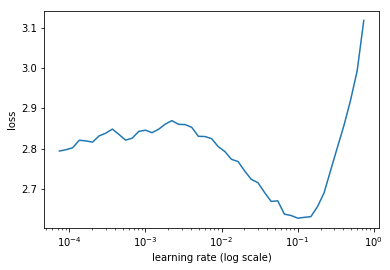

In [10]:
learn.sched.plot()

In [11]:
lr=1e-2
learn.precompute=False
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 2.258698, val_loss: 1.789843, accuracy: 0.385995
epoch:   1, train_loss: 1.928262, val_loss: 1.648425, accuracy: 0.420718



In [12]:
learn.unfreeze()
lrs = [lr/9,lr/3, lr]
learn.fit(lrs, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 1.502355, val_loss: 1.086049, accuracy: 0.653935
epoch:   1, train_loss: 1.031659, val_loss: 0.876943, accuracy: 0.712963
epoch:   2, train_loss: 0.698309, val_loss: 0.716939, accuracy: 0.760995



In [13]:
sz=512
lr=1e-2
lrs = [lr/12,lr/3, lr]

In [14]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms,test_name='test')

In [15]:
sz=512
lr=1e-2
lrs = [lr/12,lr/3, lr]
bs=16
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.489040, val_loss: 0.571401, accuracy: 0.825595
epoch:   1, train_loss: 0.440630, val_loss: 0.563469, accuracy: 0.823810
epoch:   2, train_loss: 0.384560, val_loss: 0.504597, accuracy: 0.843452



In [16]:
learn.save(f'resnet_{sz}')

In [17]:
sz=512
learn.load(f'resnet_{sz}')

In [18]:
test_log_probs,_ = learn.TTA(is_test=True)

In [19]:
test_probs = np.mean(np.exp(test_log_probs), axis=0)
test_preds = np.argmax(test_probs,axis=1)
test_fnames = data.test_ds.fnames
test_fnames = [x.replace(r'test/', '') for x in test_fnames]
test_camera = [data.classes[i] for i in test_preds]
final_sumbit_arr = np.stack((test_fnames,test_camera), axis=1 )
np.savetxt(f'{PATH}submit.csv', final_sumbit_arr, fmt='%s,%s', header='fname,camera',comments="")